**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

**Capturing name of the PC**

In [2]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [3]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if PC_name_str == 'science12':
    cores = 42        
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

science12
42


**Defining constants**

In [4]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [5]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [6]:
%%time
z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
print(df_gal.describe())


            x[kpc/h]       y[kpc/h]       z[kpc/h]     m[Msol/h]
count   93097.000000   93097.000000   93097.000000  9.309700e+04
mean   325576.133087  322500.028738  320613.762863  3.993206e+11
std    184863.273960  182799.587421  183249.915097  3.995129e+11
min         1.864417      10.164207       0.260974  1.800010e+11
25%    163866.950000  166201.380000  162514.560000  2.161480e+11
50%    332449.620000  329260.160000  319925.780000  2.784900e+11
75%    483949.000000  475466.120000  478698.410000  4.192930e+11
max    639996.190000  639980.940000  639993.120000  1.077460e+13
CPU times: user 94.7 ms, sys: 12.4 ms, total: 107 ms
Wall time: 106 ms


**Reading clusters dataset**

In [7]:
df_clusters_orig = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

df_clusters_orig.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6080.000000,6080.000000,6080.000000,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,326416.401838,322055.402286,321308.240244,6.356245e+13,2.109102,-1.647297,-4.296055
std,186021.550694,182650.899538,183665.854310,4.851698e+13,316.064539,306.226537,286.454388
min,19.163288,152.653880,87.370949,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,160978.575000,164793.430000,161863.925000,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,338884.565000,333274.345000,322110.075000,4.801630e+13,-3.619450,1.969450,-8.055475
75%,486227.747500,473556.765000,478893.610000,6.945502e+13,206.816750,207.755750,181.532000
max,639887.560000,639933.380000,639848.380000,7.438200e+14,1197.640000,1164.960000,1201.260000


In [8]:
#removing cluster at edges of the survey volume as done by Tanimura et al. 2020

# df_clusters = df_clusters_orig

def edge_clus_remover(clus_cube_size):
    
    low_bound = clus_cube_size//2
    upp_bound = 640000 - (clus_cube_size//2)
    
    df_clusters = df_clusters_orig[(df_clusters_orig['x[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['x[kpc/h]'] < upp_bound) & 
                                   (df_clusters_orig['y[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['y[kpc/h]'] < upp_bound) & 
                                   (df_clusters_orig['z[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['z[kpc/h]'] < upp_bound)]
    
#     print(df_clusters.describe())
    
    return df_clusters

# print(clus_cube_size//2)
# edge_clus_remover(clus_cube_size)

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [9]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.593806237


2.3806208666680271

**Calculating mean density of the simulation box for Eq. 1**

In [10]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((640000//cell_size, 640000//cell_size, 640000//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    delta_gal_mean = np.mean(gals_in_cell)
    
    return delta_gal_mean

**Calculating Overdensity field for Eq. 1**

In [11]:
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

def overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, clus_cube_size):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                           (df_gal['x[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                           (df_gal['y[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                           (df_gal['y[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                           (df_gal['z[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                           (df_gal['z[kpc/h]'] < (clus_z + clus_cube_size//2))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x - clus_cube_size//2)
    df_gal_cube['y[kpc/h]'] -= (clus_y - clus_cube_size//2)
    df_gal_cube['z[kpc/h]'] -= (clus_z - clus_cube_size//2)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
    
    #smoothing the overdensity of galaxies
    delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    
    return delta_matter


**Calculating differential, numerator & denominator for Eq. 1**

In [12]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [13]:
def clus_velocity_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, vel_terms, sigma_in_pix, 
                       clus_cube_size):
    
    delta_matter = overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, 
                                          clus_cube_size)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    vx_est = pre_fac * np.sum(integrand_x)
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    vy_est = pre_fac * np.sum(integrand_y)
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    vz_est = pre_fac * np.sum(integrand_z)
    
    return(vx_est, vy_est, vz_est)


**Calculating sigma for smoothing**

In [14]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

**Calling funtion to estimate the velocity of clusters**

In [100]:
%%time

cell_size_assess = pd.DataFrame(columns=['Cell Size', 'Cube Size', 'Clusters', 'Mean - Vx', 'Mean - Vy', 'Mean - Vz', 
                                         'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 'r - Vy','r - Vz'])

clus_cube_size = 240000

for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]: #h^-1 kpc, size of pixel or cell
    
    print(cell_size)

    sigma_in_pix = sigma_calc(cell_size)

    df_clusters = edge_clus_remover(clus_cube_size)

    delta_gal_mean = delta_gal_mean_func(cell_size)

    vel_terms = vel_terms_calc(cell_size, clus_cube_size)

    clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                          [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                          [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                          [clus_cube_size]*len(df_clusters)))
    
    pool = multi.Pool(processes = cores)
    v_est = pool.starmap(clus_velocity_calc, clus_param)

    vx_est_list = [i[0] for i in v_est]
    vy_est_list = [i[1] for i in v_est]
    vz_est_list = [i[2] for i in v_est]
    
    error_x = df_clusters['vx[km/s]'] - vx_est_list
    error_y = df_clusters['vy[km/s]'] - vy_est_list
    error_z = df_clusters['vz[km/s]'] - vz_est_list
    
    cell_size_assess = cell_size_assess.append({'Cell Size':cell_size, 
                             'Cube Size':clus_cube_size,
                             'Clusters': len(df_clusters),
                             'Mean - Vx': round(np.mean(error_x),1), 
                             'Mean - Vy': round(np.mean(error_y),1), 
                             'Mean - Vz': round(np.mean(error_z),1), 
                             'SD - Vx': round(np.std(error_x),1), 
                             'SD - Vy': round(np.std(error_y),1),
                             'SD - Vz': round(np.std(error_z),1), 
                             'r - Vx': round(np.corrcoef(df_clusters['vx[km/s]'], vx_est_list)[1,0],2),
                             'r - Vy': round(np.corrcoef(df_clusters['vy[km/s]'], vy_est_list)[1,0],2),
                             'r - Vz': round(np.corrcoef(df_clusters['vz[km/s]'], vz_est_list)[1,0],2)}, 
                             ignore_index=True)
    
    

Process ForkPoolWorker-3022:
Process ForkPoolWorker-3014:
Process ForkPoolWorker-3036:


KeyboardInterrupt: 

Process ForkPoolWorker-2990:
Process ForkPoolWorker-3018:
Process ForkPoolWorker-2993:
Process ForkPoolWorker-2998:
Process ForkPoolWorker-2989:
Process ForkPoolWorker-3006:
Process ForkPoolWorker-3016:
Process ForkPoolWorker-3001:
Process ForkPoolWorker-3000:
Process ForkPoolWorker-2985:
Process ForkPoolWorker-3003:
Process ForkPoolWorker-2996:
Process ForkPoolWorker-3033:
Process ForkPoolWorker-2997:
Process ForkPoolWorker-3002:
Process ForkPoolWorker-2986:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-3013:
Process ForkPoolWorker-3030:
Process ForkPoolWorker-3020:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

In [ ]:
cell_size_assess

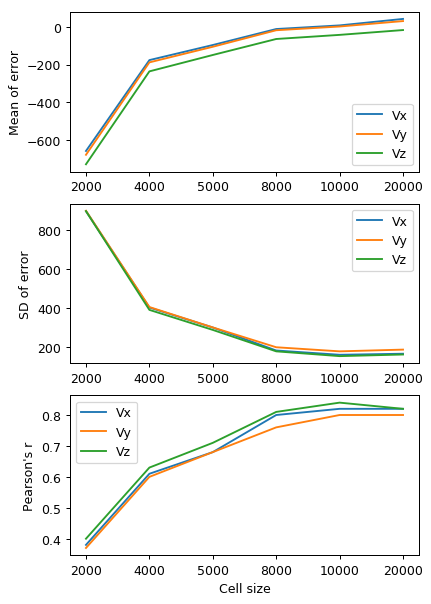

In [83]:
plt.figure(dpi = dpi, figsize = (5,8))
plt.subplot(311)
plt.plot(cell_size_assess['Mean - Vx'], label = 'Vx')
plt.plot(cell_size_assess['Mean - Vy'], label = 'Vy')
plt.plot(cell_size_assess['Mean - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('Mean of error')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000])

plt.subplot(312)
plt.plot(cell_size_assess['SD - Vx'], label = 'Vx')
plt.plot(cell_size_assess['SD - Vy'], label = 'Vy')
plt.plot(cell_size_assess['SD - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('SD of error')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000])

plt.subplot(313)
plt.plot(cell_size_assess['r - Vx'], label = 'Vx')
plt.plot(cell_size_assess['r - Vy'], label = 'Vy')
plt.plot(cell_size_assess['r - Vz'], label = 'Vz')
plt.legend()
plt.xlabel('Cell size')
plt.ylabel('Pearson\'s r')
plt.xticks([0, 1, 2, 3, 4, 5], [2000, 4000, 5000, 8000, 10000, 20000]);

In [ ]:
%%time
cell_size = 10000                      #h^-1 kpc, size of pixel or cell

cube_size_assess = pd.DataFrame(columns=['Cell Size', 'Cube Size', 'Clusters', 'Mean - Vx', 'Mean - Vy', 'Mean - Vz', 
                                         'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 'r - Vy','r - Vz'])

for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:
    
    print(clus_cube_size)
    
    sigma_in_pix = sigma_calc(cell_size)
    
    df_clusters = edge_clus_remover(clus_cube_size)

    delta_gal_mean = delta_gal_mean_func(cell_size)

    vel_terms = vel_terms_calc(cell_size, clus_cube_size)

    clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                          [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                          [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                          [clus_cube_size]*len(df_clusters)))

    pool = multi.Pool(processes = cores)
    v_est = pool.starmap(clus_velocity_calc, clus_param)

    vx_est_list = [i[0] for i in v_est]
    vy_est_list = [i[1] for i in v_est]
    vz_est_list = [i[2] for i in v_est]

    error_x = df_clusters['vx[km/s]'] - vx_est_list
    error_y = df_clusters['vy[km/s]'] - vy_est_list
    error_z = df_clusters['vz[km/s]'] - vz_est_list

    cube_size_assess = cube_size_assess.append({'Cell Size': cell_size,
                                                'Cube Size': clus_cube_size,
                                                'Clusters': len(df_clusters),
                                                'Mean - Vx': round(np.mean(error_x),1), 
                                                'Mean - Vy': round(np.mean(error_y),1), 
                                                'Mean - Vz': round(np.mean(error_z),1), 
                                                'SD - Vx': round(np.std(error_x),1), 
                                                'SD - Vy': round(np.std(error_y),1),
                                                'SD - Vz': round(np.std(error_z),1), 
                                                'r - Vx': round(np.corrcoef(df_clusters['vx[km/s]'], vx_est_list)[1,0],2),
                                                'r - Vy': round(np.corrcoef(df_clusters['vy[km/s]'], vy_est_list)[1,0],2),
                                                'r - Vz': round(np.corrcoef(df_clusters['vz[km/s]'], vz_est_list)[1,0],2)}, 
                                                ignore_index=True)


In [ ]:
cube_size_assess

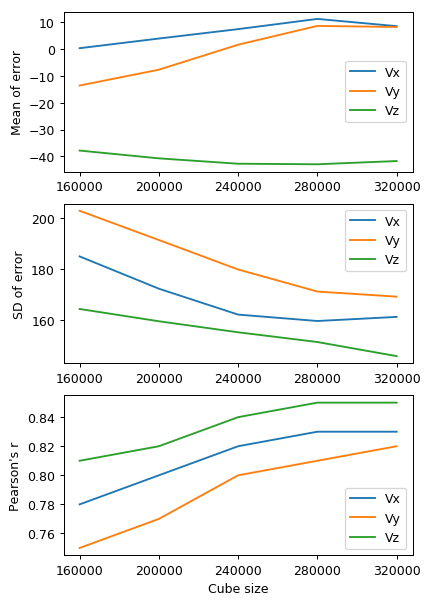

In [92]:
plt.figure(dpi = dpi, figsize = (5,8))
plt.subplot(311)
plt.plot(cube_size_assess['Mean - Vx'], label = 'Vx')
plt.plot(cube_size_assess['Mean - Vy'], label = 'Vy')
plt.plot(cube_size_assess['Mean - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('Mean of error')
plt.xticks([0, 1, 2, 3, 4], [160000, 200000, 240000, 280000, 320000])

plt.subplot(312)
plt.plot(cube_size_assess['SD - Vx'], label = 'Vx')
plt.plot(cube_size_assess['SD - Vy'], label = 'Vy')
plt.plot(cube_size_assess['SD - Vz'], label = 'Vz')
plt.legend()
plt.ylabel('SD of error')
plt.xticks([0, 1, 2, 3, 4], [160000, 200000, 240000, 280000, 320000])

plt.subplot(313)
plt.plot(cube_size_assess['r - Vx'], label = 'Vx')
plt.plot(cube_size_assess['r - Vy'], label = 'Vy')
plt.plot(cube_size_assess['r - Vz'], label = 'Vz')
plt.legend()
plt.xlabel('Cube size')
plt.ylabel('Pearson\'s r')
plt.xticks([0, 1, 2, 3, 4], [160000, 200000, 240000, 280000, 320000]);

In [36]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi, figsize = (10,12))

    plt.subplot(3,2,1)
    plt.scatter(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vx - scatter plot')

    plt.subplot(3,2,2)
    error_x = df_clusters_est_err['vx[km/s]'] - df_clusters_est_err['vx_est[km/s]']
    plt.hist(error_x, bins = 100)
    plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    minus_one = {-1}
    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f'Mean: {round(np.mean(error_x), 1)} km/s', transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f'SD: {round(np.std(error_x), 1)} km/s', transform=plt.gca().transAxes)
    r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes)

    plt.title('Vx error - histogram')




    plt.subplot(3,2,3)
    plt.scatter(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vy - scatter plot')

    plt.subplot(3,2,4)
    error_y = df_clusters_est_err['vy[km/s]'] - df_clusters_est_err['vy_est[km/s]']
    plt.hist(error_y, bins = 100)
    plt.xlabel('Error in V$_{\mathrm{y}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    minus_one = {-1}
    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f'Mean: {round(np.mean(error_y), 1)} km/s', transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f'SD: {round(np.std(error_y), 1)} km/s', transform=plt.gca().transAxes)
    r_vy = np.corrcoef(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vy, 2)}', transform=plt.gca().transAxes)

    plt.title('Vy error - histogram')




    plt.subplot(3,2,5)
    plt.scatter(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vz - scatter plot')

    plt.subplot(3,2,6)
    error_z = df_clusters_est_err['vz[km/s]'] - df_clusters_est_err['vz_est[km/s]']
    plt.hist(error_z, bins = 100)
    plt.xlabel('Error in V$_{\mathrm{z}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    minus_one = {-1}
    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f'Mean: {round(np.mean(error_z), 1)} km/s', transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f'SD: {round(np.std(error_z), 1)} km/s', transform=plt.gca().transAxes)
    r_vz = np.corrcoef(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vz, 2)}', transform=plt.gca().transAxes)

    plt.title('Vz error - histogram')

    os.system(f'mkdir Plots/v_scatter_hist/{clus_cube_size_actual}')
    plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
    plt.tight_layout()
    plt.savefig(f'Plots/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}.png')
    plt.close()

In [16]:
%%time
cell_size = 10000                      #h^-1 kpc, size of pixel or cell

cube_cell_size_assess = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 'Cube Size Set', 'Clusters', 'Mean - Vx', 'Mean - Vy', 
                                              'Mean - Vz', 'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 'r - Vy','r - Vz'])

for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:
    for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:
        
        print(cell_size, clus_cube_size)
                
        no_of_cells = clus_cube_size//cell_size
        
        clus_cube_size_actual = clus_cube_size
        
        if no_of_cells % 2 != 0:
            clus_cube_size = clus_cube_size + cell_size
        
        sigma_in_pix = sigma_calc(cell_size)

        df_clusters = edge_clus_remover(clus_cube_size)

        delta_gal_mean = delta_gal_mean_func(cell_size)

        vel_terms = vel_terms_calc(cell_size, clus_cube_size)

        clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                              [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                              [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                              [clus_cube_size]*len(df_clusters)))

        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        df_clusters_est_err = df_clusters.copy()

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_err[km/s]'] = df_clusters_est_err['vx[km/s]'] - df_clusters_est_err['vx_est[km/s]']
        df_clusters_est_err['vy_err[km/s]'] = df_clusters_est_err['vy[km/s]'] - df_clusters_est_err['vy_est[km/s]']
        df_clusters_est_err['vz_err[km/s]'] = df_clusters_est_err['vz[km/s]'] - df_clusters_est_err['vz_est[km/s]']
        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual)
        
        clear_output(wait=False)

        cube_cell_size_assess = cube_cell_size_assess.append({'Cell Size': cell_size,
                'Act Cube Size': clus_cube_size_actual,
                'Cube Size Set': clus_cube_size,
                'Clusters': len(df_clusters),
                'Mean - Vx': round(np.mean(df_clusters_est_err['vx_err[km/s]']),1), 
                'Mean - Vy': round(np.mean(df_clusters_est_err['vy_err[km/s]']),1), 
                'Mean - Vz': round(np.mean(df_clusters_est_err['vz_err[km/s]']),1), 
                'SD - Vx': round(np.std(df_clusters_est_err['vx_err[km/s]']),1), 
                'SD - Vy': round(np.std(df_clusters_est_err['vy_err[km/s]']),1),
                'SD - Vz': round(np.std(df_clusters_est_err['vz_err[km/s]']),1), 
                'r - Vx': round(np.corrcoef(df_clusters['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0],2),
                'r - Vy': round(np.corrcoef(df_clusters['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0],2),
                'r - Vz': round(np.corrcoef(df_clusters['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0],2)}, 
                ignore_index=True)
        
        clus_cube_size = clus_cube_size_actual
        


CPU times: user 1min 38s, sys: 5min 47s, total: 7min 25s
Wall time: 6min 6s


In [18]:
cube_cell_size_assess.to_excel('cube_cell_size_assess.xlsx')
cube_cell_size_assess

,Cell Size,Act Cube Size,Cube Size Set,Clusters,Mean - Vx,Mean - Vy,Mean - Vz,SD - Vx,SD - Vy,SD - Vz,r - Vx,r - Vy,r - Vz
0,2000.0,160000.0,160000.0,2473.0,-690.1,-684.1,-711.9,899.7,892.2,894.2,0.35,0.34,0.39
1,4000.0,160000.0,160000.0,2473.0,-191.6,-199.8,-227.9,408.4,410.6,397.0,0.57,0.56,0.62
2,5000.0,160000.0,160000.0,2473.0,-107.8,-118.1,-142.8,309.6,315.7,300.8,0.65,0.64,0.70
3,8000.0,160000.0,160000.0,2473.0,-20.6,-33.3,-57.2,205.3,221.7,188.7,0.75,0.72,0.78
4,10000.0,160000.0,160000.0,2473.0,0.3,-13.6,-37.8,184.9,202.7,164.4,0.78,0.75,0.81
5,20000.0,160000.0,160000.0,2473.0,33.2,14.3,-12.1,187.9,207.3,172.3,0.79,0.76,0.80
6,2000.0,200000.0,200000.0,1928.0,-681.4,-682.3,-706.0,892.3,890.7,893.5,0.36,0.36,0.40
7,4000.0,200000.0,200000.0,1928.0,-184.9,-197.1,-227.8,401.8,402.5,395.1,0.59,0.59,0.62
8,5000.0,200000.0,200000.0,1928.0,-102.7,-116.0,-143.9,302.7,305.0,294.9,0.67,0.66,0.70
9,8000.0,200000.0,208000.0,1825.0,-15.0,-25.9,-60.3,192.8,207.4,183.3,0.78,0.75,0.80


In [19]:
r_Vz_table = pd.DataFrame()

for name, group in cube_cell_size_assess.groupby("Cell Size"):
    if r_Vz_table.empty:
        r_Vz_table = group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name})
    else:
        r_Vz_table = r_Vz_table.join(group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name}))

r_Vz_table

,2000.0,4000.0,5000.0,8000.0,10000.0,20000.0
Act Cube Size,,,,,,
160000.0,0.39,0.62,0.70,0.78,0.81,0.80
200000.0,0.40,0.62,0.70,0.80,0.82,0.82
240000.0,0.40,0.63,0.71,0.81,0.84,0.82
280000.0,0.41,0.64,0.72,0.82,0.85,0.84
320000.0,0.41,0.62,0.72,0.82,0.85,0.83


In [46]:
x_axis = np.arange(0,6)

# for clus_cube_size in [240000]:
for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:

    plt.figure(dpi = dpi, figsize = (5,9))
    plt.subplot(311)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Mean of error (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r'Mean of velocity error | Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), fontsize = 11)

    plt.subplot(312)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('SD of error (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r'SD of velocity error | Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), fontsize = 11)

    plt.subplot(313)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Pearson\'s r')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r"Pearson's r | Cube size: {} h$^{}$kpc".format(clus_cube_size, minus_one), fontsize = 11)
    plt.subplots_adjust(hspace = 0.6)
    plt.tight_layout()
    plt.savefig(f'Plots/cell_size_exam/clus_box_{clus_cube_size}.png')
    plt.close()

In [50]:

x_axis = np.arange(0,5)

# for cell_size in [5000]:
for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:

    plt.figure(dpi = dpi, figsize = (5,10))
    plt.subplot(311)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('Mean of error (km/s)')
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.ylim(-750,50)
    minus_one = {-1}
    plt.title(r'Mean of velocity error | Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), fontsize = 11)

    plt.subplot(312)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('SD of error (km/s)')
    plt.ylim(100, 950)
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.title(r'SD of velocity error | Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), fontsize = 11)

    plt.subplot(313)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('Pearson\'s r')
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.ylim(0.30, 0.90)
    plt.title(r"Pearson's r | Cell size: {} h$^{}$kpc".format(cell_size, minus_one), fontsize = 11)

    plt.subplots_adjust(hspace = 0.7)
    plt.tight_layout()
    plt.savefig(f'Plots/clus_bos_size_exam/cell_size_{cell_size}.png')
#     plt.savefig(f'Plots/clus_bos_size_exam/free_y_lim/cell_size_{cell_size}.png')
    plt.close()

In [20]:
%%time
cell_size = 10000                      #h^-1 kpc, size of pixel or cell

clus_cube_size = 240000

no_of_cells = clus_cube_size//cell_size
if no_of_cells % 2 != 0:
    clus_cube_size = clus_cube_size + cell_size
    
df_clusters = edge_clus_remover(clus_cube_size)

sigma_in_pix = sigma_calc(cell_size)

delta_gal_mean = delta_gal_mean_func(cell_size)

vel_terms = vel_terms_calc(cell_size, clus_cube_size)

clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                      [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                      [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                      [clus_cube_size]*len(df_clusters)))

pool = multi.Pool(processes = cores)
v_est = pool.starmap(clus_velocity_calc, clus_param)

df_clusters_est_err = df_clusters.copy()

df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

df_clusters_est_err['vx_err[km/s]'] = df_clusters_est_err['vx[km/s]'] - df_clusters_est_err['vx_est[km/s]']
df_clusters_est_err['vy_err[km/s]'] = df_clusters_est_err['vy[km/s]'] - df_clusters_est_err['vy_est[km/s]']
df_clusters_est_err['vz_err[km/s]'] = df_clusters_est_err['vz[km/s]'] - df_clusters_est_err['vz_est[km/s]']

CPU times: user 2.22 s, sys: 50.4 s, total: 52.6 s
Wall time: 18.9 s


**Assessing the correctness of the estimated velocities**

CPU times: user 691 ms, sys: 1.35 s, total: 2.04 s
Wall time: 806 ms


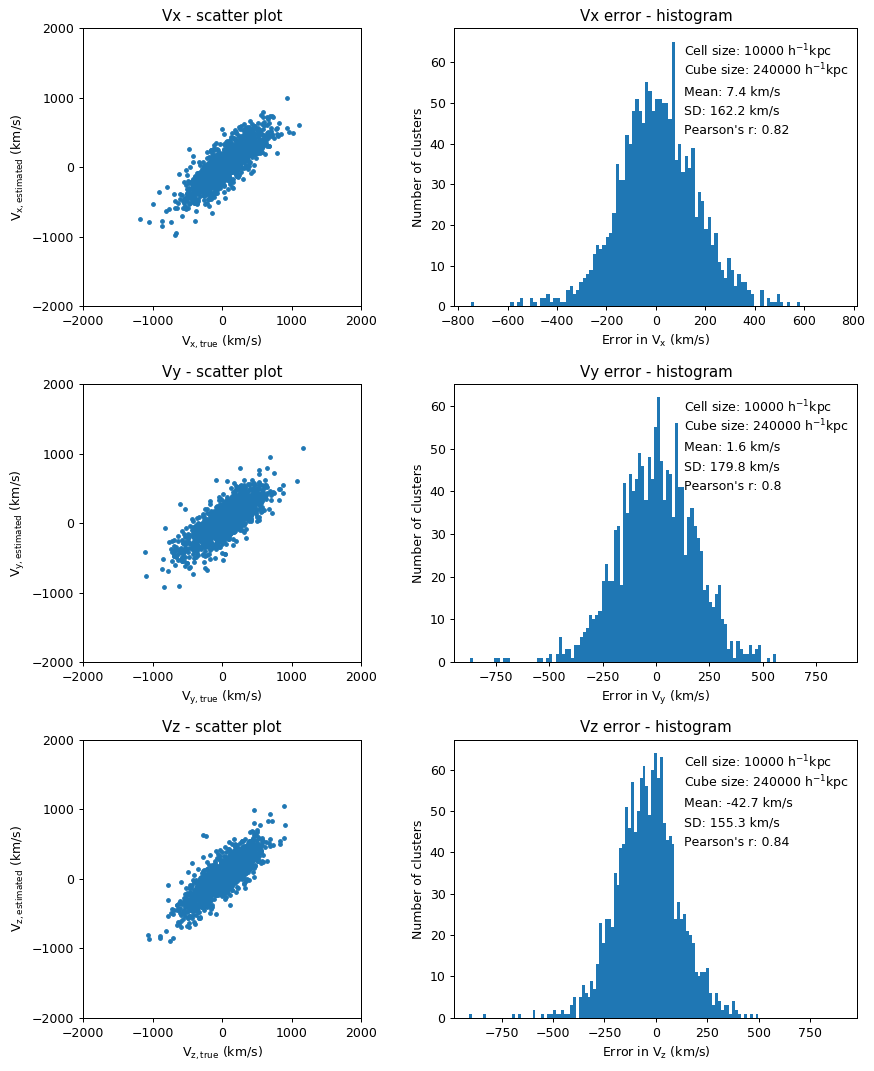

In [35]:
%%time

fig = plt.figure(dpi = dpi, figsize = (10,12))

plt.subplot(3,2,1)
plt.scatter(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vx - scatter plot')

plt.subplot(3,2,2)
error_x = df_clusters_est_err['vx[km/s]'] - df_clusters_est_err['vx_est[km/s]']
plt.hist(error_x, bins = 100)
plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

minus_one = {-1}
plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.76, f'Mean: {round(np.mean(error_x), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.57, 0.69, f'SD: {round(np.std(error_x), 1)} km/s', transform=plt.gca().transAxes)
r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
plt.text(0.57, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes)

plt.title('Vx error - histogram')




plt.subplot(3,2,3)
plt.scatter(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'], s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vy - scatter plot')

plt.subplot(3,2,4)
error_y = df_clusters_est_err['vy[km/s]'] - df_clusters_est_err['vy_est[km/s]']
plt.hist(error_y, bins = 100)
plt.xlabel('Error in V$_{\mathrm{y}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

minus_one = {-1}
plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.76, f'Mean: {round(np.mean(error_y), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.57, 0.69, f'SD: {round(np.std(error_y), 1)} km/s', transform=plt.gca().transAxes)
r_vy = np.corrcoef(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0]
plt.text(0.57, 0.62, f'Pearson\'s r: {round(r_vy, 2)}', transform=plt.gca().transAxes)

plt.title('Vy error - histogram')




plt.subplot(3,2,5)
plt.scatter(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'], s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vz - scatter plot')

plt.subplot(3,2,6)
error_z = df_clusters_est_err['vz[km/s]'] - df_clusters_est_err['vz_est[km/s]']
plt.hist(error_z, bins = 100)
plt.xlabel('Error in V$_{\mathrm{z}}$ (km/s)')
plt.ylabel('Number of clusters')
x_low, x_high = plt.xlim()
plt.xlim(x_low, abs(x_low))

minus_one = {-1}
plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
plt.text(0.57, 0.76, f'Mean: {round(np.mean(error_z), 1)} km/s', transform=plt.gca().transAxes)
plt.text(0.57, 0.69, f'SD: {round(np.std(error_z), 1)} km/s', transform=plt.gca().transAxes)
r_vz = np.corrcoef(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0]
plt.text(0.57, 0.62, f'Pearson\'s r: {round(r_vz, 2)}', transform=plt.gca().transAxes)

plt.title('Vz error - histogram')

# os.system(f'mkdir Plots/{clus_cube_size}')
plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
plt.tight_layout()
# plt.savefig(f'Plots/{clus_cube_size}/v_scatter_hist_{cell_size}.png')

0